In [1]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

def predict_with_random_forest(df, freq='5min', forecast_days=7):
    df = df.dropna(subset=['occupancy', 'temperature'])
    df['_time'] = pd.to_datetime(df['_time'], format='mixed', utc=True, errors='coerce')
    df = df.dropna(subset=['_time'])
    df['_time'] = df['_time'].dt.tz_convert(None)

    # Features temporelles
    df['minute'] = df['_time'].dt.minute
    df['hour'] = df['_time'].dt.hour
    df['dayofweek'] = df['_time'].dt.dayofweek

    # On prépare X et y pour les deux cibles
    features = ['minute', 'hour', 'dayofweek']
    X = df[features]
    y_occ = df['occupancy']
    y_temp = df['temperature']

    # Modèles
    model_occ = RandomForestRegressor()
    model_temp = RandomForestRegressor()
    model_occ.fit(X, y_occ)
    model_temp.fit(X, y_temp)

    # Création des timestamps pour les 7 prochains jours
    future_times = pd.date_range(start=df['_time'].max() + pd.Timedelta(freq), 
                                 periods=int((pd.Timedelta(days=forecast_days) / pd.Timedelta(freq))), 
                                 freq=freq)

    # Création des features temporelles futures
    future_df = pd.DataFrame({
        '_time': future_times,
        'minute': future_times.minute,
        'hour': future_times.hour,
        'dayofweek': future_times.dayofweek
    })

    # Prédiction
    future_df['occupancy'] = model_occ.predict(future_df[features])
    future_df['occupancy'] = (future_df['occupancy'] >= 0.5).astype(int)

    future_df['temperature'] = model_temp.predict(future_df[features])

    return future_df[['_time', 'occupancy', 'temperature']]


In [55]:
new_df = predict_with_random_forest(df)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16220\1739259972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_time'] = pd.to_datetime(df['_time'], format='mixed', utc=True, errors='coerce')


In [56]:
new_df.tail(10)

,_time,occupancy,temperature
2006,2025-05-15 10:45:00,0,22.038135
2007,2025-05-15 10:50:00,0,22.092718
2008,2025-05-15 10:55:00,0,22.211694
2009,2025-05-15 11:00:00,0,22.127328
2010,2025-05-15 11:05:00,0,22.229904
2011,2025-05-15 11:10:00,0,22.051128
2012,2025-05-15 11:15:00,0,22.387400
2013,2025-05-15 11:20:00,0,22.315657
2014,2025-05-15 11:25:00,0,22.392655
2015,2025-05-15 11:30:00,0,22.481181


In [57]:
set(new_df['occupancy'])

{0, 1}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16220\1739259972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_time'] = pd.to_datetime(df['_time'], format='mixed', utc=True, errors='coerce')


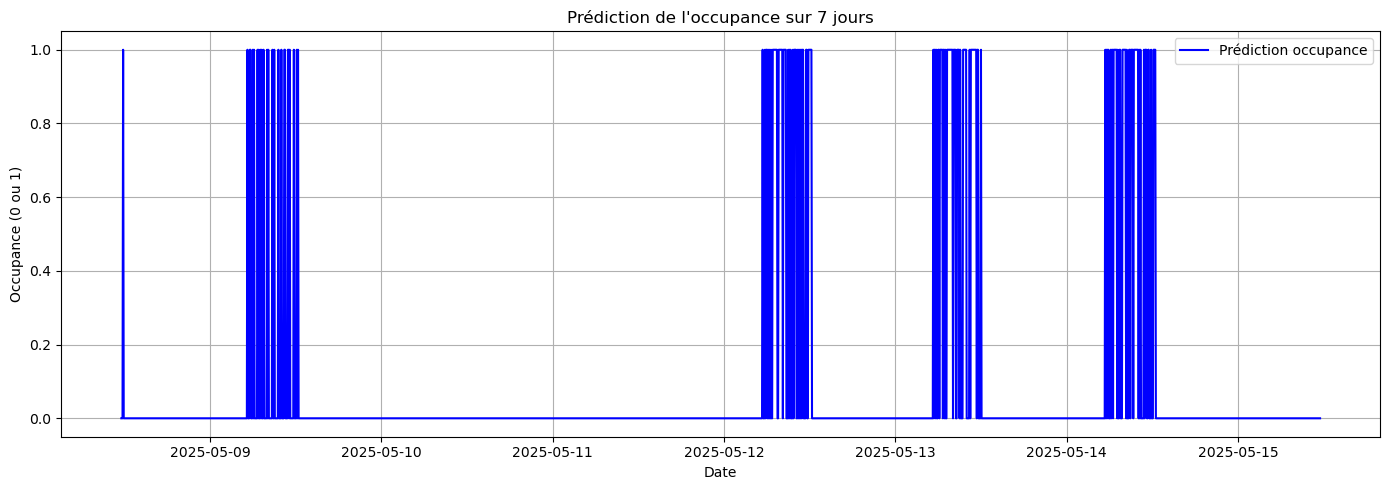

In [59]:
import matplotlib.pyplot as plt

# Appel de la fonction de prédiction
future_df = predict_with_random_forest(df)

# Affichage du résultat pour occupance
plt.figure(figsize=(14, 5))
plt.plot(future_df['_time'], future_df['occupancy'], label='Prédiction occupance', color='blue')
plt.xlabel('Date')
plt.ylabel('Occupance (0 ou 1)')
plt.title('Prédiction de l\'occupance sur 7 jours')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16220\1739259972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_time'] = pd.to_datetime(df['_time'], format='mixed', utc=True, errors='coerce')


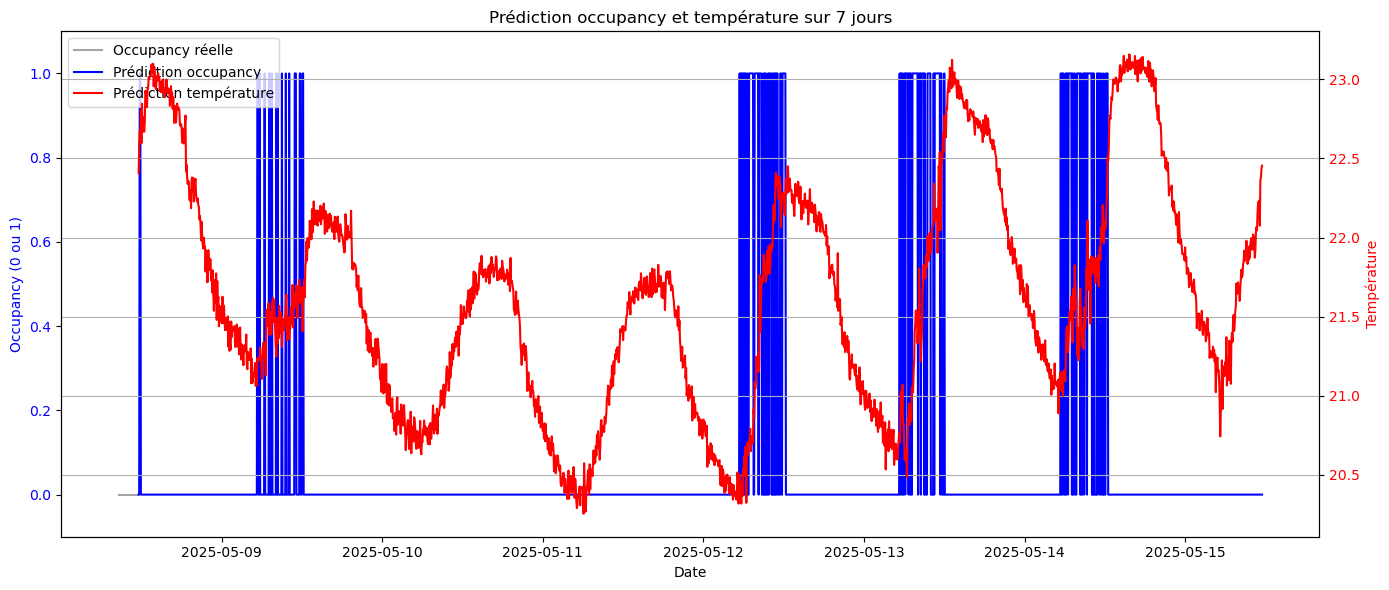

In [60]:
import matplotlib.pyplot as plt

def plot_occupancy_temperature(future_df, df):
    recent_df = df[df['_time'] > df['_time'].max() - pd.Timedelta(hours=3)]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Courbe occupancy (axe Y gauche)
    ax1.plot(recent_df['_time'], recent_df['occupancy'], label='Occupancy réelle', color='gray', alpha=0.7)
    ax1.plot(future_df['_time'], future_df['occupancy'], label='Prédiction occupancy', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Occupancy (0 ou 1)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(-0.1, 1.1)  # Pour bien encadrer le binaire

    # Deuxième axe Y pour la température
    ax2 = ax1.twinx()
    ax2.plot(future_df['_time'], future_df['temperature'], label='Prédiction température', color='red')
    ax2.set_ylabel('Température', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Légendes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title("Prédiction occupancy et température sur 7 jours")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation après prédiction
future_df = predict_with_random_forest(df)
plot_occupancy_temperature(future_df, df)


In [23]:
df.tail(50)

,_time,occupancy,temperature,precip_rate
32533,2025-05-08 10:30:00+00:00,0.0,21.000000,NaN
32534,2025-05-08 10:35:00+00:00,0.0,23.870000,NaN
32535,2025-05-08 10:35:00+00:00,0.0,23.680000,NaN
32536,2025-05-08 10:35:00+00:00,0.0,20.435000,NaN
32537,2025-05-08 10:35:00+00:00,0.0,21.000000,NaN
32538,2025-05-08 10:40:00+00:00,0.0,23.870000,NaN
32539,2025-05-08 10:40:00+00:00,0.0,23.680000,NaN
32540,2025-05-08 10:40:00+00:00,0.0,20.500000,NaN
32541,2025-05-08 10:40:00+00:00,0.0,21.000000,NaN
32542,2025-05-08 10:45:00+00:00,0.0,23.870000,NaN


In [18]:
df = df.groupby('_time').mean().reset_index()

In [19]:
df

,_time,Unnamed: 0,occupancy,temperature,precip_rate,humidity,co2
0,2025-04-15 11:00:00+00:00,0.0,0.0,23.060000,NaN,NaN,NaN
1,2025-04-15 11:05:00+00:00,2.0,0.0,21.435556,0.0,NaN,NaN
2,2025-04-15 11:10:00+00:00,5.0,0.0,21.456667,0.0,NaN,NaN
3,2025-04-15 11:15:00+00:00,8.0,0.0,21.456667,0.0,NaN,NaN
4,2025-04-15 11:20:00+00:00,11.0,0.0,21.456667,0.0,NaN,NaN
...,...,...,...,...,...,...,...
8619,2025-05-15 09:40:00+00:00,47450.5,0.0,23.828333,NaN,25.045000,NaN
8620,2025-05-15 09:45:00+00:00,47480.5,0.5,23.828333,NaN,25.062073,NaN
8621,2025-05-15 09:50:00+00:00,47498.5,0.0,23.833333,NaN,25.270000,NaN
8622,2025-05-15 09:55:00+00:00,47528.5,0.5,23.838333,NaN,25.270000,NaN


In [4]:
def make_prediction(df):
    df['_time'] = pd.to_datetime(df['_time'])
    latest_time = df['_time'].max()
    one_week_ago = latest_time - pd.Timedelta(days=7)
    last_week_df = df[df['_time'] > one_week_ago].copy()
    last_week_df['_time'] += pd.Timedelta(days=7)
    return last_week_df

In [5]:
new = make_prediction(df)

In [8]:
new.tail()

,_time,occupancy,_value_1,_field_1,placement_3,unit_1,_value_2,_field_2,unit_2,unit_3,temperature_3,placement_4,unit_4,temperature_4
103194,2025-04-07 09:05:00+00:00,0,17.87,temperature,window,°C,23.2,temperature,°C,°C,22.81,door,°C,22.87
103195,2025-04-07 09:05:00+00:00,0,17.87,temperature,window,°C,23.2,temperature,°C,°C,22.81,window,°C,14.93
103196,2025-04-07 09:05:00+00:00,0,17.87,temperature,window,°C,23.2,temperature,°C,°C,22.81,window,°C,17.87
103197,2025-04-07 09:05:00+00:00,0,17.87,temperature,window,°C,23.2,temperature,°C,°C,23.20,door,°C,22.87
103198,2025-04-07 09:05:00+00:00,0,17.87,temperature,window,°C,23.2,temperature,°C,°C,23.20,window,°C,14.93
